In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange

In [2]:
colors = ["#1b9e77","#d95f02","#7570b3","#e7298a","#66a61e"]

In [3]:
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['figure.dpi']=200
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

#### Stochastic differential equations with memory
We have $N$ persistent Brownian walkers moving in a 1D box of size $L$, governed by the following set of Langevin equations
$$\gamma \dot{x}(t)=\mathbf{F}_i + \mathbf{\xi}_i$$
$$\dot{\xi}_i(t)=-\frac{\mathbf{\xi}_i}{\tau} + \sqrt{\frac{2D}{\tau^2}}\mathbf{\eta}_i(t)

In [4]:
# Generate gaussian random numbers of mean 0 and variance 1
def gauss_rnd(size):
    return np.random.normal(0, 1, size)

In [5]:
# We will use the Euler-Maruyama method to integrate the stochastic differential equations
def euler_maruyama_step(x, xi, F, gamma, D, tau, dt):
    N = len(x)
    # Update the noise term xi
    dxi = (-xi / tau) * dt + np.sqrt(2 * D / tau**2) * gauss_rnd(N) * np.sqrt(dt)
    xi_new = xi + dxi
    # Update the position x
    dx = (F / gamma) * dt + (xi / gamma) * dt
    x_new = x + dx
    return x_new, xi_new

# @jit(nopython=True, parallel=True)
def simulate(N, L, gamma, D, tau, F, dt, total_time):
    num_steps = int(total_time / dt)
    x = np.random.uniform(0, L, N)  # Initial positions
    xi = np.zeros(N)  # Initial noise terms
    positions = np.zeros((num_steps, N))
    xi_history = np.zeros((num_steps, N))
    
    
    for step in range(num_steps):
        if step % (num_steps // 3) == 0:
            print(f'Simulation progress: {step / num_steps * 100:.1f}%')
        x, xi = euler_maruyama_step(x, xi, F, gamma, D, tau, dt)
        # Apply periodic boundary conditions
        x = x % L
        xi_history[step] = xi
        positions[step] = x
    
    return positions, xi_history

# Add this function
@jit(nopython=True, parallel=True)
def calculate_msd_parallel(unwrapped):
    num_steps = unwrapped.shape[0]
    msd = np.zeros(num_steps)
    
    for lag in prange(num_steps):
        sum_sq = 0.0
        count = (num_steps - lag) * unwrapped.shape[1]
        
        for t in range(num_steps - lag):
            for i in range(unwrapped.shape[1]):
                diff = unwrapped[t + lag, i] - unwrapped[t, i]
                sum_sq += diff * diff
        
        msd[lag] = sum_sq / count
    
    return msd

# Replace your get_msd function
def get_msd(positions, L):
    diff = np.diff(positions, axis=0)
    diff = diff - L * np.round(diff / L)
    unwrapped = np.vstack([positions[0:1], positions[0] + np.cumsum(diff, axis=0)])
    return calculate_msd_parallel(unwrapped)

def analitical_msd(D, tau, time):
    return 2 * D * (time - tau * (1 - np.exp(-time / tau)))

@jit(nopython=True, parallel=True)
def correlation_xi(xi_history):
    num_steps, N = xi_history.shape
    corr = np.zeros(num_steps)
    
    for t in range(num_steps):
        prod = xi_history[t:] * xi_history[:num_steps - t]
        corr[t] = np.mean(prod)
    
    return corr

def analitical_corr(D, tau, time):
    return (D / tau) * np.exp(-time / tau)

In [7]:
N = 50
L = 100
D = 1
gamma = 1
tau = 10
F = 0
dt = 0.01
total_time = 1000
positions, xi_history = simulate(N, L, gamma, D, tau, F, dt, total_time)
msd = get_msd(positions,L)
corr = correlation_xi(xi_history)

Simulation progress: 0.0%
Simulation progress: 33.3%
Simulation progress: 66.7%
Simulation progress: 100.0%


Simulating for tau=1
Simulation progress: 0.0%
Simulation progress: 33.3%
Simulation progress: 66.7%
Simulation progress: 100.0%
Simulating for tau=10
Simulation progress: 0.0%
Simulation progress: 33.3%
Simulation progress: 66.7%
Simulation progress: 100.0%
Simulating for tau=100
Simulation progress: 0.0%
Simulation progress: 33.3%
Simulation progress: 66.6%
Simulation progress: 99.9%


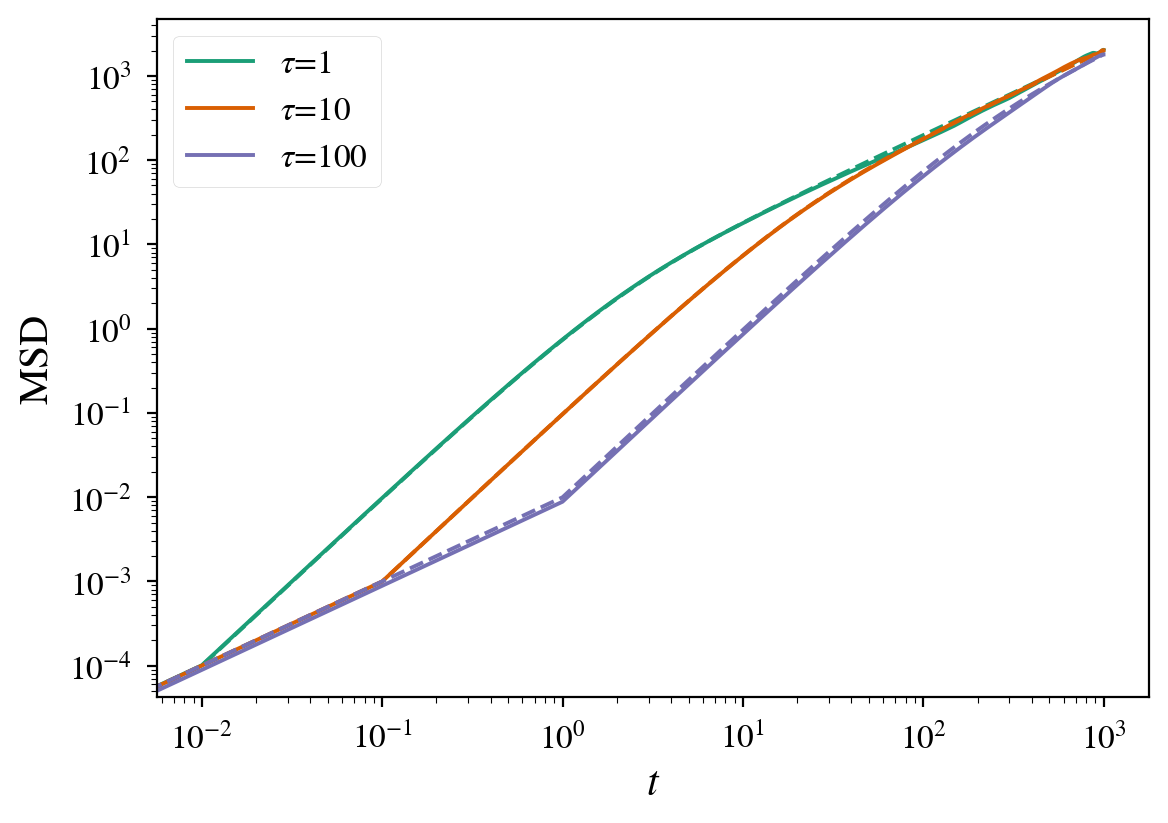

In [8]:
# Plot the MSD compared to the analytical result
N = 50
L = 100
D = 1
gamma = 1
F = 0
total_time = 1000
correlations = []
for t in [1, 10, 100]:
    print(f'Simulating for tau={t}')
    col = colors[int(np.log10(t))]
    tau = t
    dt = tau/100
    time_msd = np.arange(0, total_time, dt)
    positions, xi_history = simulate(N, L, gamma, D, tau, F, dt, total_time)
    msd = get_msd(positions,L)
    correlations.append(correlation_xi(xi_history))
    plt.loglog(time_msd, analitical_msd(D, tau, time_msd),color =col, linestyle='--')
    plt.loglog(time_msd, msd, label=f'$\\tau$={tau}', color=col)
plt.xlabel('$t$')
plt.ylabel('MSD')
# plt.title('Mean Squared Displacement of Persistent Brownian Walkers')
plt.legend()
plt.show()

Simulation progress: 0.0%
Simulation progress: 33.3%
Simulation progress: 66.7%
Simulation progress: 100.0%
Simulation progress: 0.0%
Simulation progress: 33.3%
Simulation progress: 66.7%
Simulation progress: 100.0%
Simulation progress: 0.0%
Simulation progress: 33.3%
Simulation progress: 66.6%
Simulation progress: 99.9%


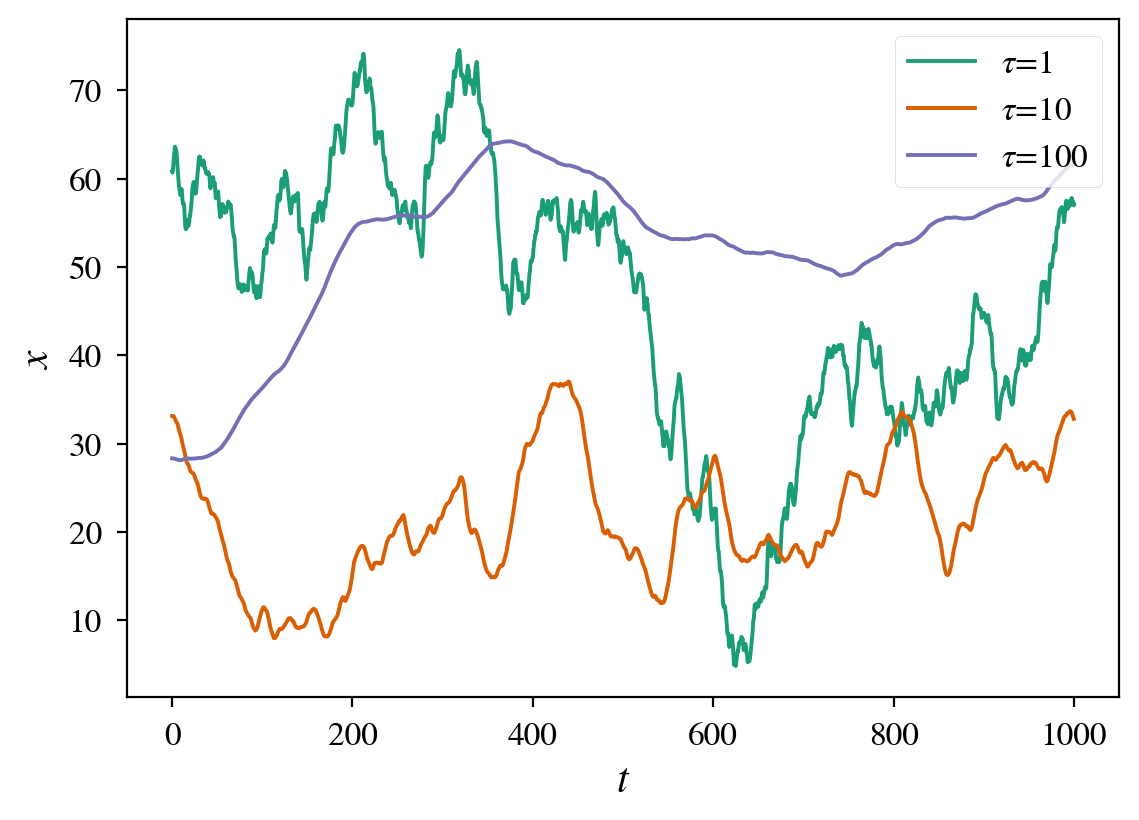

In [17]:
# Plot a typical trajectory
N = 50
L = 100
D = 1
gamma = 1
F = 0
total_time = 1000

tau_values = [1, 10, 100]
for i,tau in enumerate(tau_values):
    col = colors[i]
    dt = tau/100
    time = np.arange(0, total_time, dt)
    positions, xi_history = simulate(N, L, gamma, D, tau, F, dt, total_time)
    plt.plot(time, positions[:,0], label=f'$\\tau$={tau}', color=col)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.legend()
plt.show()

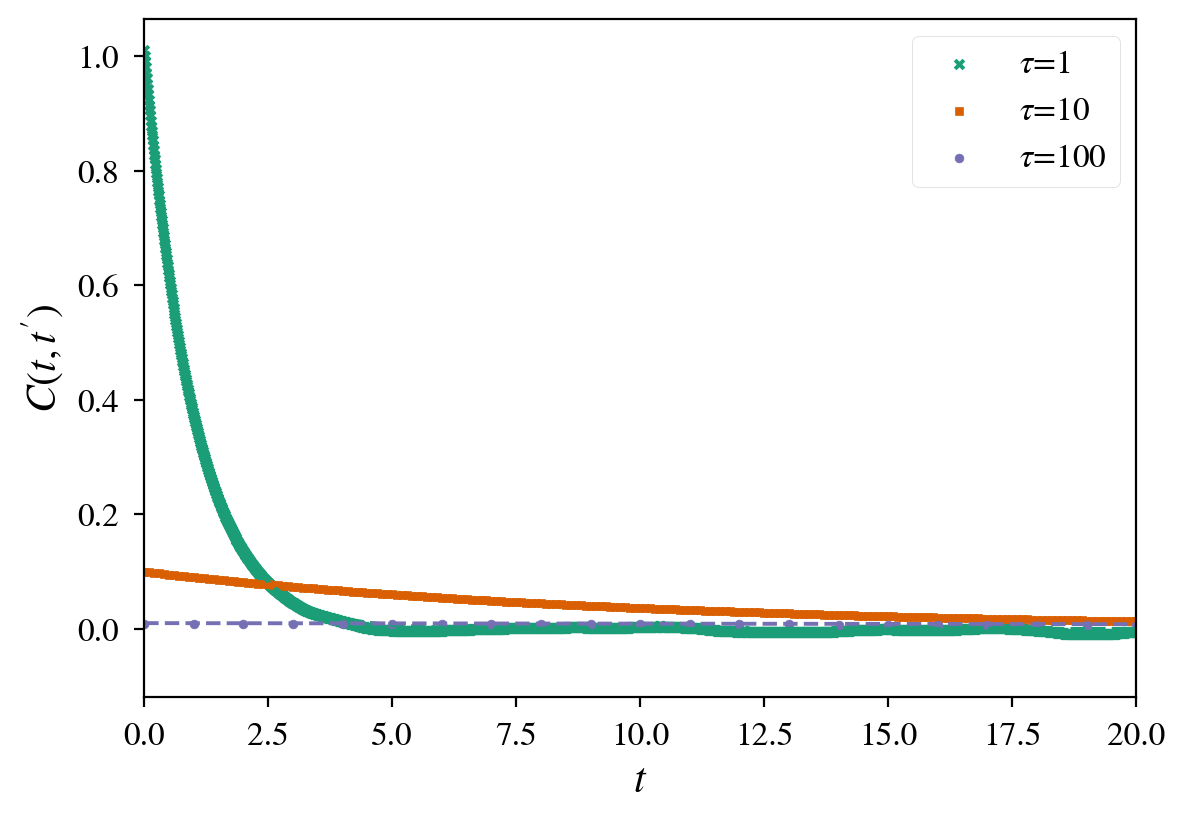

In [26]:
# Plot the correlation function of xi
markers = [ 'x', 's', 'o' ]
for i, t in enumerate([1, 10, 100]):
    col = colors[i]
    corr = correlations[i]
    tau = t
    dt = tau/100
    total_time = 1000
    time_corr = np.arange(0, total_time, dt)
    plt.scatter(time_corr, corr, color=col, label=f'$\\tau$={tau}', s=10, marker=markers[i] )
    plt.plot(time_corr, analitical_corr(D, tau, time_corr),c=col, linestyle='--')
plt.legend()
plt.xlabel('$t$')
plt.xlim(0,20)
plt.ylabel('$C(t, t\')$')
# plt.title('Correlation Function of Noise Term xi')  
plt.show()

Now we will study, the MSD and displacement under random forces. 

$$ \mathbf{f}_i=\epsilon_i f \mathbf{u}_x $$

where $\epsilon_i=\pm 1$, with equal probability.

Using $\tau = 10$, and $f=0, 0.001, 0.01, 0.1,1$. Average over 10 independent noise realizations.

In [6]:
# New function for simulation
def f_simulate(N, L, gamma, D, tau, epsilon, F, dt, total_time):
    num_steps = int(total_time / dt)
    x = np.random.uniform(0, L, N)  # Initial positions
    xi = np.zeros(N)  # Initial noise terms
    
    # Assign random ±1 to each particle
    epsilon_i = epsilon
    
    # Store positions (unwrapped for MSD calculation)
    positions = np.zeros((num_steps, N))
    xi_history = np.zeros((num_steps, N))
    
    for step in range(1, num_steps):
        # Apply force with direction epsilon_i
        F_applied = epsilon_i * F
        x, xi = euler_maruyama_step(x, xi, F_applied, gamma, D, tau, dt)
        
        # Apply periodic boundary conditions
        x = x % L
        xi_history[step] = xi
        positions[step] = x
    
    return positions, xi_history

# Calculate displacement function
def get_displacement(positions, L, epsilon):
    num_steps, N = positions.shape
    
    # Unwrap positions
    unwrapped = np.copy(positions)
    for t in range(1, num_steps):
        diff = positions[t] - positions[t-1]
        diff = diff - L * np.round(diff / L)
        unwrapped[t] = unwrapped[t-1] + diff
    
    # Calculate displacement along epsilon direction
    displacement = np.zeros(num_steps)
    for lag in range(num_steps):
        disp = (unwrapped[lag:] - unwrapped[:num_steps-lag]) * epsilon
        displacement[lag] = np.mean(disp)
    
    return displacement


In [28]:
# Calculate MSD for f_simulate function
realizations = 10
N = 50
L = 100
D = 1
gamma = 1
total_time = 1000
displacements = []
msd_values = []
tau = 10
dt = tau/100
for i,f in enumerate([0, 0.001, 0.01, 0.1, 1.0]):
    print(f"Simulating for force f = {f}")
    a = []
    b = []
    for _ in range(realizations - 1):
        epsilon = np.random.choice([-1, 1], size=N)
        positions, xi_history = f_simulate(N, L, gamma, D, tau, epsilon, f, dt, total_time)
        msd = get_msd(positions,L)
        disp = get_displacement(positions,L, epsilon)
        a.append(disp)
        b.append(msd)
    displacements.append(np.mean(a, axis=0))
    msd_values.append(np.mean(b, axis=0))

Simulating for force f = 0
Simulating for force f = 0.001
Simulating for force f = 0.01
Simulating for force f = 0.1
Simulating for force f = 1.0


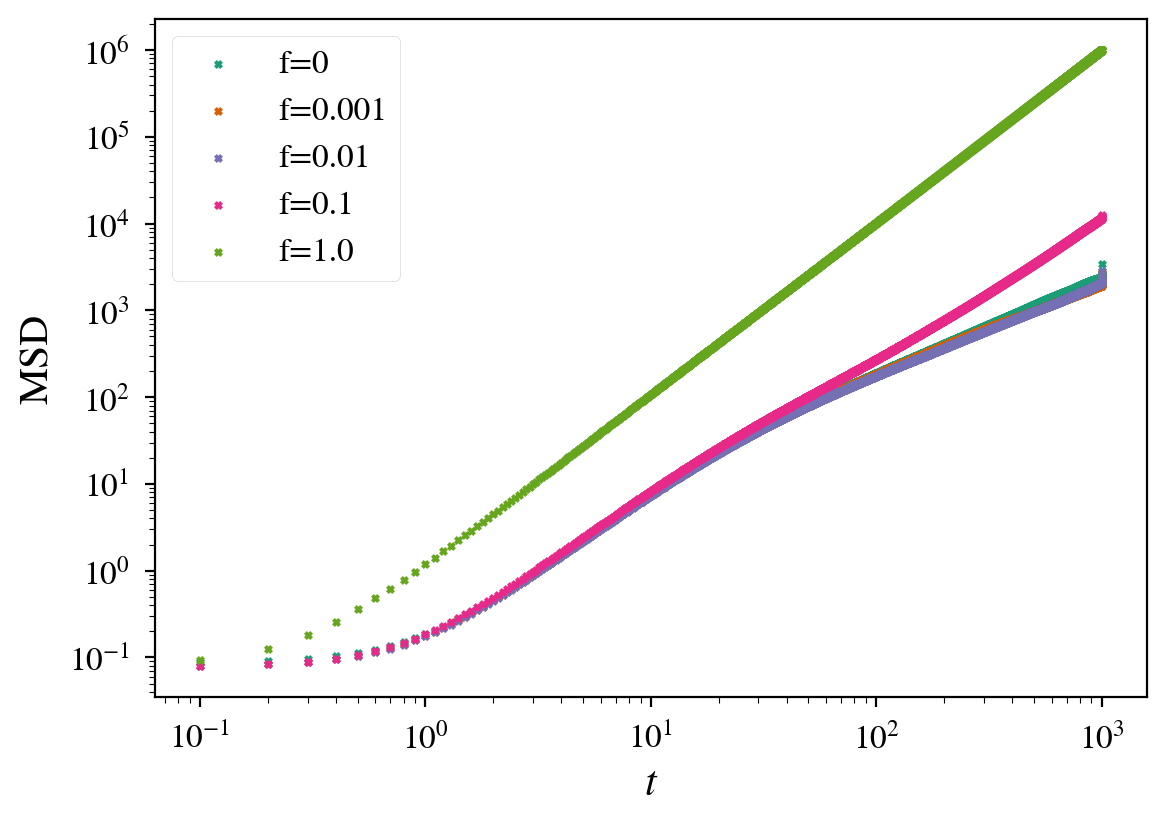

In [33]:
#plot msd
time_msd = np.arange(0, total_time, dt)
for i,f in enumerate([0, 0.001, 0.01, 0.1, 1.0]):
    col = colors[i]
    plt.scatter(time_msd, msd_values[i], label=f'f={f}', color=col, s=5, marker='x')
plt.xlabel('$t$')
plt.ylabel('MSD')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


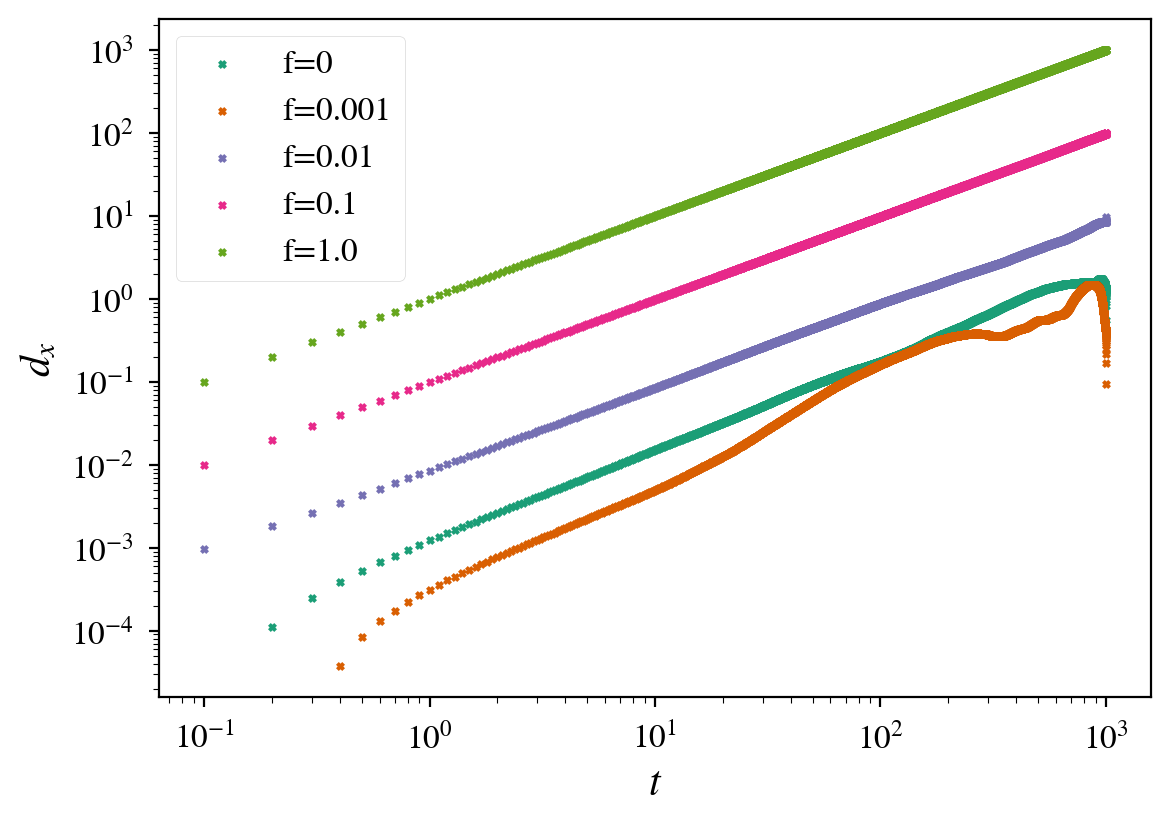

In [32]:
#plot displacement
time_msd = np.arange(0, total_time, dt)
for i,f in enumerate([0, 0.001, 0.01, 0.1, 1.0]):
    col = colors[i]
    plt.scatter(time_msd, displacements[i], label=f'f={f}', color=col, s=5, marker='x')
plt.xlabel('$t$')
plt.ylabel('$d_x$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

We want to measure

$$ \mu = \lim_{t \to \infty}\frac{d_x}{ft}$$

and 

$$ D = \lim_{t \to \infty} \frac{\Delta^2_x (t)}{2t} $$

for several values of $\tau$. Plot $\mu$ and $D$ vs $\tau $.

In [7]:
# Function to extract mu and D as defined above
def extract_mu_D(displacement, msd, time, f):
    # Use last 20% of trajectory for linear fit (long-time regime)
    fit_start = int(0.6 * len(time))
    fit_end = len(time)
    
    t_fit = time[fit_start:fit_end]
    
    # Mobility: fit d_x vs t, then divide by f
    if f > 0:
        # Linear fit: d_x = μ*f*t + constant
        coeffs = np.polyfit(t_fit, displacement[fit_start:fit_end], 1)
        mu = coeffs[0] / f  # slope / f
    else:
        mu = np.nan
        
    # Diffusion: fit MSD vs t
    # Linear fit: MSD = 2*D*t + constant
    coeffs_msd = np.polyfit(t_fit, msd[fit_start:fit_end], 1)
    D_measured = coeffs_msd[0] / 2  # slope / 2
    
    return mu, D_measured

In [8]:
# Parameters
N = 50
L = 100.0
gamma = 1.0
D_input = 1.0  # Input diffusion coefficient

n_realizations = 10

# Different tau values
tau_values = [0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0]
f_values = [0.001, 0.01, 0.1, 1.0]

mu_results = np.zeros((len(tau_values), len(f_values)))
D_results = np.zeros((len(tau_values), len(f_values)))
mu_std = np.zeros((len(tau_values), len(f_values)))
D_std = np.zeros((len(tau_values), len(f_values)))

In [12]:
for f in f_values:
    print(f"Simulating for force f = {f}")
    for tau in tau_values:
        print(f"  tau = {tau}")
        dt = tau / 100
        total_time = tau*100
        time = np.arange(0, total_time, dt)
        mu_realizations = []
        D_realizations = []
        for _ in range(n_realizations):
            epsilon = np.random.choice([-1, 1], size=N)
            positions, xi_history = f_simulate(N, L, gamma, D_input, tau, epsilon, f, dt, total_time)
            msd = get_msd(positions,L)
            disp = get_displacement(positions,L, epsilon)
            mu, D_measured = extract_mu_D(disp, msd, time, f)
            mu_realizations.append(mu)
            D_realizations.append(D_measured)
        mu_results[tau_values.index(tau), f_values.index(f)] = np.mean(mu_realizations)
        D_results[tau_values.index(tau), f_values.index(f)] = np.mean(D_realizations)
        mu_std[tau_values.index(tau), f_values.index(f)] = np.std(mu_realizations)
        D_std[tau_values.index(tau), f_values.index(f)] = np.std(D_realizations)

# Print results
            

Simulating for force f = 0.001
  tau = 0.5
  tau = 1.0
  tau = 2.0
  tau = 5.0
  tau = 10.0
  tau = 20.0
  tau = 50.0
Simulating for force f = 0.01
  tau = 0.5
  tau = 1.0
  tau = 2.0
  tau = 5.0
  tau = 10.0
  tau = 20.0
  tau = 50.0
Simulating for force f = 0.1
  tau = 0.5
  tau = 1.0
  tau = 2.0
  tau = 5.0
  tau = 10.0
  tau = 20.0
  tau = 50.0
Simulating for force f = 1.0
  tau = 0.5
  tau = 1.0
  tau = 2.0
  tau = 5.0
  tau = 10.0
  tau = 20.0
  tau = 50.0


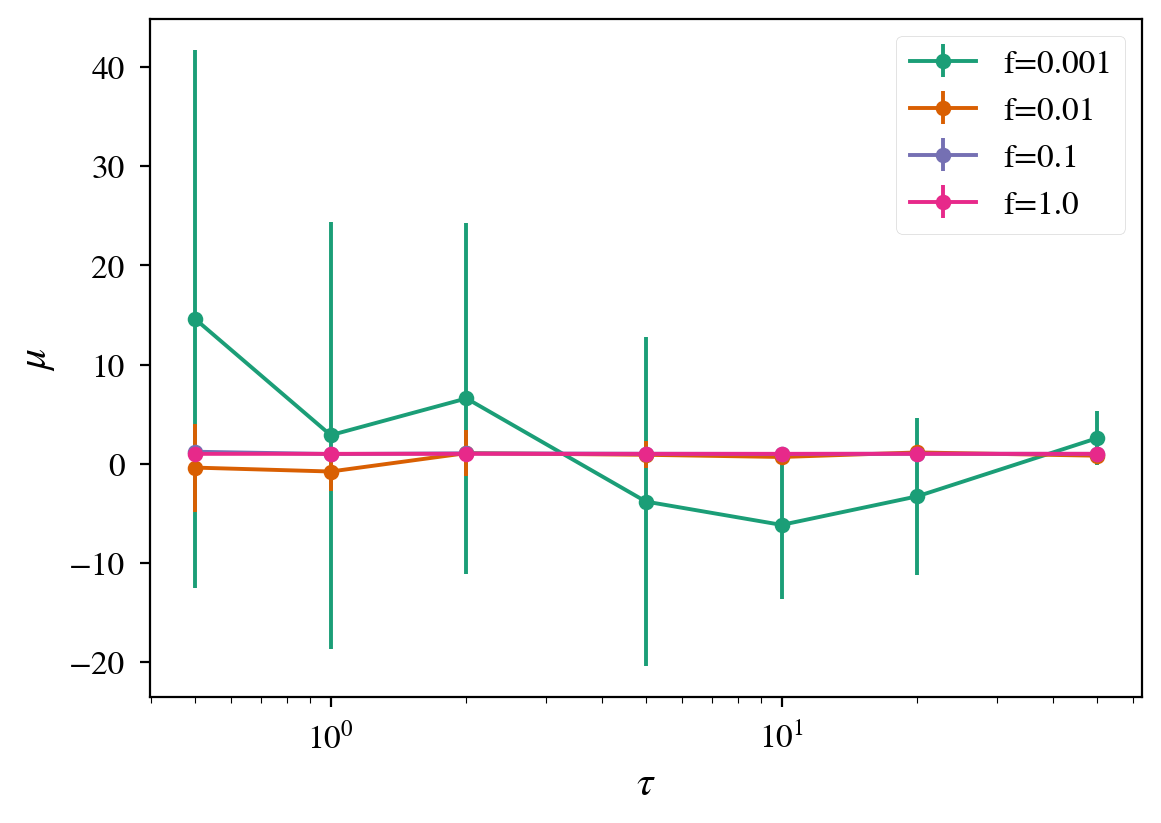

In [13]:
# plot mu vs tau for different f
for i,f in enumerate(f_values):
    col = colors[i]
    plt.errorbar(tau_values, mu_results[:,i], yerr=mu_std[:,i], label=f'f={f}', color=col, fmt='o-')
plt.xlabel('$\\tau$')
plt.ylabel('$\mu$')
plt.xscale('log')
plt.legend()
plt.show()

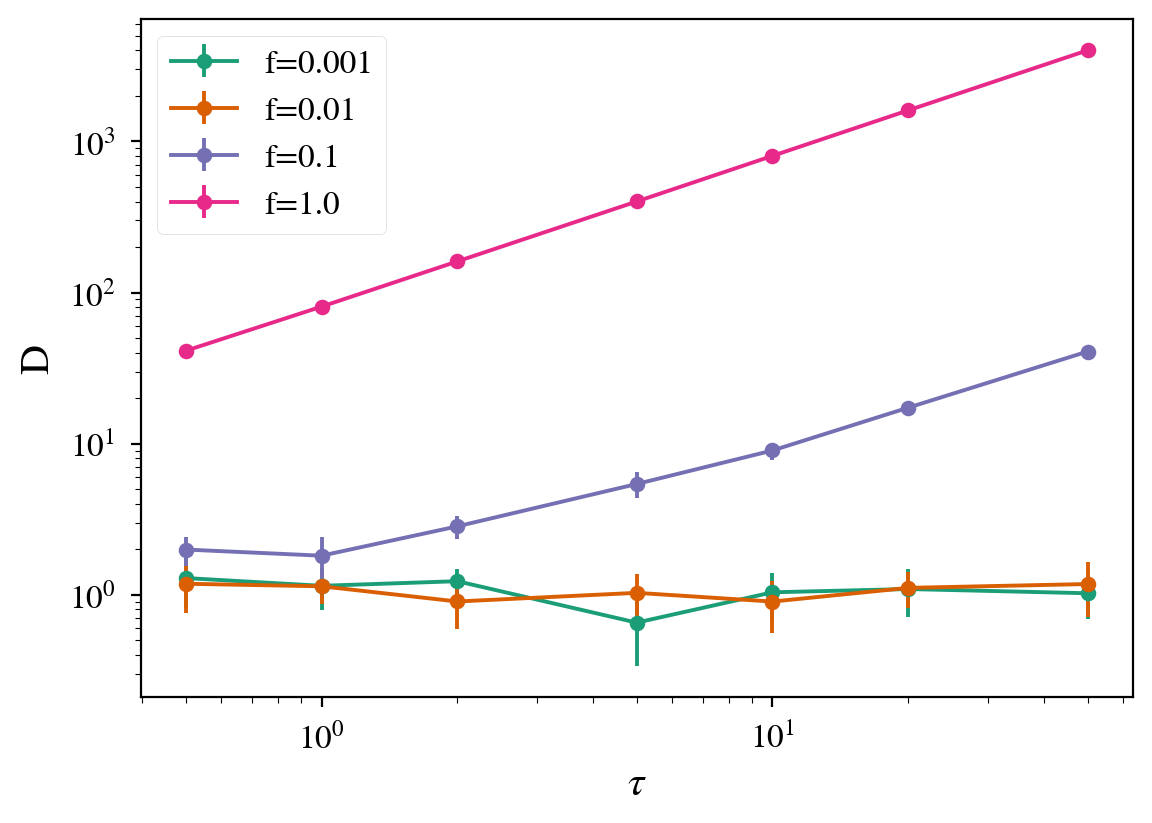

In [14]:
# Plot D vs tau for different f
for i,f in enumerate(f_values):
    col = colors[i]
    plt.errorbar(tau_values, D_results[:,i], yerr=D_std[:,i], label=f'f={f}', color=col, fmt='o-')
plt.xlabel('$\\tau$')
plt.ylabel('D')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()